In [1]:
from matplotlib import pyplot as plt
import numpy as np
import classifier_utils
from classifier_utils import cnn_model, preprocess_img, get_class
%matplotlib inline
import glob
import os
from skimage import io
from skimage import transform
import keras
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
import vgg16


Using TensorFlow backend.


# Loading CIFAR10 dataset

* -x_train: training set samples
* -y_train: training set labels

+ -x_test: test set samples
+ -y_test: test set labels

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170369024/170498071 [============================>.] - ETA: 0s

###### Training set dimension:

In [ ]:
print (x_train.shape)

### Switch RGB to BGR order (BGR is expected as a default input).

In [3]:
x_train = x_train.astype('float32')

In [4]:
x_train = x_train[:, :, :, ::-1]  

# Subtract ImageNet mean pixel 
x_train[:, :, :, 0] -= 103
x_train[:, :, :, 1] -= 116
x_train[:, :, :, 2] -= 123

In [2]:
#print (x_train) #double check changed values

### Image resizing. 
Vgg16 takes minimum size of 48x48!

Pay attention on example below:
```python
x_train_vgg[i] = transform.resize(x_train[i], (64, 64), order=0, preserve_range=True)
```
1. transform.resize changes values by default into range from -1 to 1.
2. To avoid mixing data types need to use: 
```python 
preserve_range=True
```

In [6]:
x_train_vgg = np.zeros((50000,64,64,3))

for i in range(50000):
    x_train_vgg[i] = transform.resize(x_train[i], (64, 64), order=0, preserve_range=True) #need to preserve range for Float32

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Validation set
Validation set is used during training. 

#### To sum up
###### Training set: 
Used to adjust the weights on the neural network.

###### Validation set: 
Used to minimize overfitting by proper verifyication. 
###### Overfitting: 
If the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then you're overfitting your neural network and you should stop training.

###### Testing set: 
Used only for final testing to confirm the actual predictive power of the current network.

In [ ]:
size_of_dataset = 50000 #in case of CIFAR 

mask = np.random.rand(size_of_dataset) < 0.8  #array of boolean variables

training_set = x_train_vgg[mask]
training_labels = y_train[mask]

validation_set = x_train_vgg[~mask]
validation_labels = y_train[~mask]

In [7]:
#set size of sample and number of classes
IMG_SIZE = 64 
NUM_CLASSES = 10

### Reducing amount of pictures

In [8]:
x_train_vgg = x_train_vgg[0:50000] #bigger value
y_train_vgg = y_train[0:50000]

### Sample printing

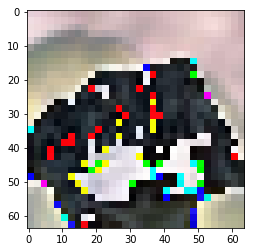

In [9]:
single_image = x_train_vgg[25:26]
plt.imshow(single_image[0])         

# Setting up model
Current example uses Vgg16 model. In case of this project there are only 10 categories so model need to be set with some changes on last layer. 
Last layer is removed with: 

```python 
include_top=False
```
then all layers are set to trainable and new Dense layer with 10 categories is added. 

In [10]:
model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(64,64,3), pooling=max)

57712640/58889256 [============================>.] - ETA: 0s

### Setting all layers to trainable.
In this scenario all layers were set to trainable. 

In [12]:
for layer in model.layers: layer.trainable=True

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

### Alternative way to add last layer and activation 

In [14]:
#model.add(Dense(NUM_CLASSES, activation='softmax')) .add doesn't work for VGG16

last = model.output

x = Flatten()(last)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(model.input, preds)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

# Training
#### Set optimizer for tweaks (leraning rate lr=0.001 to lr=0.0001) !Unquote Adam!

In [16]:
Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [17]:
model.compile(optimizer=Adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
#NO validation
model.fit(x_train_vgg, y_train_vgg, batch_size=128, epochs=3) 
#with validation
#model.fit(training_set, training_labels, batch_size=128, nb_epoch=1, validation_data=(validation_set, validation_labels))

Epoch 1/3
50000/50000 [==============================] - 312s - loss: 0.8204 - acc: 0.7436   
Epoch 2/3
50000/50000 [==============================] - 304s - loss: 0.3151 - acc: 0.8920   
Epoch 3/3
50000/50000 [==============================] - 304s - loss: 0.1907 - acc: 0.9349   


# Evaluation

In [19]:
x_test = x_test.astype('float32')

In [20]:
x_test = x_test[:, :, :, ::-1]  

# Subtract ImageNet mean pixel 
x_test[:, :, :, 0] -= 103
x_test[:, :, :, 1] -= 116
x_test[:, :, :, 2] -= 123

###### Test set need to be in same size as a training set

In [21]:
x_test_vgg = np.zeros((10000,64,64,3))

for i in range(10000):
    x_test_vgg[i] = transform.resize(x_test[i], (64, 64), order=0, preserve_range=True)

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
print (x_test_vgg.shape)

(10000, 64, 64, 3)


In [23]:
model.evaluate(x_test_vgg, y_test)

10000/10000 [==============================] - 23s    


[0.30457848844528196, 0.89939999999999998]